# Pairs Trading Based on Cointegration

Pairs trading is a market neutral trading strategy and it belongs to statistical arbitrage. The basic idea is to select two stocks which move similarly, sell the high priced stock and buy the low priced stock where there is a price divergence between the pairs.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Coint test
from math import floor
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import Ridge
from hurst import compute_Hc, random_walk

# ML
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy import stats

# Data source
import yfinance as yf
import wrds

from datetime import datetime
import itertools
import requests
import copy

pd.set_option('display.max_columns', 50)

In [2]:
import matplotlib as mpl
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

## Data

### Import Exchange Data

In [3]:
# Import Exchange Data
url = 'https://api.nasdaq.com/api/screener/stocks?tableonly=true&limit=25&offset=0&download=true'

headers = {
	'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
	}
resp = requests.get(url,headers=headers)
json_data = resp.json()
exchange_data = pd.DataFrame(json_data['data']['rows'],columns=json_data['data']['headers'])
# Filter for common stock/shares
exchange_data = exchange_data[exchange_data['name'].str.contains('Common Stock')|exchange_data['name'].str.contains('Common Shares')]
# remove blank sectors
exchange_data = exchange_data[exchange_data['sector'] != '']
tickers = tuple(exchange_data['symbol'])

exchange_data

,symbol,name,lastsale,netchange,pctchange,marketCap,country,ipoyear,volume,sector,industry,url
0,A,Agilent Technologies Inc. Common Stock,$130.31,-1.18,-0.897%,37441668808.00,United States,1999,1596030,Industrials,Biotechnology: Laboratory Analytical Instruments,/market-activity/stocks/a
1,AA,Alcoa Corporation Common Stock,$40.09,-0.47,-1.159%,10356856213.00,United States,2016,3904801,Industrials,Aluminum,/market-activity/stocks/aa
4,AADI,Aadi Bioscience Inc. Common Stock,$1.99,0.03,1.531%,48983520.00,United States,,32700,Health Care,Biotechnology: Pharmaceutical Preparations,/market-activity/stocks/aadi
5,AAL,American Airlines Group Inc. Common Stock,$13.40,-0.54,-3.874%,8805555346.00,United States,,26309179,Consumer Discretionary,Air Freight/Delivery Services,/market-activity/stocks/aal
7,AAME,Atlantic American Corporation Common Stock,$1.59,-0.0461,-2.818%,32435615.00,United States,,3428,Finance,Life Insurance,/market-activity/stocks/aame
...,...,...,...,...,...,...,...,...,...,...,...,...
7015,ZVRA,Zevra Therapeutics Inc. Common Stock,$8.15,-0.28,-3.321%,428834980.00,United States,,722767,Health Care,Biotechnology: Pharmaceutical Preparations,/market-activity/stocks/zvra
7016,ZVSA,ZyVersa Therapeutics Inc. Common Stock,$2.01,-0.0012,-0.06%,2068684.00,United States,2022,11256,Health Care,Biotechnology: Pharmaceutical Preparations,/market-activity/stocks/zvsa
7017,ZWS,Zurn Elkay Water Solutions Corporation Common ...,$36.10,0.20,0.557%,6126671501.00,United States,2012,1294561,Industrials,Industrial Machinery/Components,/market-activity/stocks/zws
7018,ZYME,Zymeworks Inc. Common Stock,$13.70,-0.17,-1.226%,973349243.00,United States,,800508,Health Care,Biotechnology: Pharmaceutical Preparations,/market-activity/stocks/zyme


### Import Data From Local
If previous downloaded from WRDS and YF, import from local data to save time.

In [4]:
# Import Data (skip importing from WRDS)
# StkSecurityInfoHdr (securities info to filter active)
df_active = pd.read_csv('active_tickers.csv', sep='|') 
active_tickers = list(df_active['tradingsymbol']) # contains tickers that is currently listed
# Convert Date string to dt
date_cols = ['secinfostartdt', 'secinfoenddt', 'securitybegdt', 'securityenddt']
for date_col in date_cols:
    df_active[date_col] = df_active[date_col].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))

# Daily Market Capitalisation
daily_mkt_cap = pd.read_csv('daily_mkt_cap.csv', sep='|').rename(columns={'dlycaldt':'date'})
daily_mkt_cap['date'] = daily_mkt_cap['date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
daily_mkt_cap = daily_mkt_cap.set_index('date')

# Daily Price Vol
daily_prc_vol = pd.read_csv('daily_prc_vol.csv', sep='|').rename(columns={'dlycaldt':'date'})
daily_prc_vol['date'] = daily_prc_vol['date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
daily_prc_vol = daily_prc_vol.set_index('date')

# Daily Profti Margin
daily_npm = pd.read_csv('daily_npm.csv', sep='|')
daily_npm['date'] = daily_npm['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
daily_npm = daily_npm.set_index('date')

# Import YFinance data (skip downloading from yf)
data_px = pd.read_csv('daily_px.csv', sep='|')
data_px['Date'] = data_px['Date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
data_px = data_px.set_index('Date')

data_vol = pd.read_csv('daily_vol.csv', sep='|')
data_vol['Date'] = data_vol['Date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
data_vol = data_vol.set_index('Date')

#### Data Cleaning
Remove tickers with missing data (only run tickers with complete data). <br><br>
From securities from exchange data: 7000 tickers. <br>
After filtering for common stocks/shares: 4664 tickers.<br>
After dropping delisted tickers (reference to WRDS data): 4487 tickers.<br>
After filtering tickers with complete data (i.e. 10 years of daily market cap, trading notional volume and net profit margin): 1800 tickers.

In [5]:
# Clean Price Data
data_px = data_px.ffill()

missing_fractions = data_px.isnull().mean().sort_values()

drop_list =\
    sorted(list(missing_fractions
                [missing_fractions > 0.1] # Drop data if it has more than 10% missing data
                .index)
           )
data_px = data_px.drop(labels = drop_list, axis = 1)
# data_px

In [6]:
# ALIGN TICKERS (COLUMNS)

# Check if the tickers are present in all 3 data, only keep tickers with complete data
cond_npm = exchange_data['symbol'].isin(daily_npm.columns)
cond_mkt_cap = exchange_data['symbol'].isin(daily_mkt_cap.columns)
cond_prc_vol = exchange_data['symbol'].isin(daily_prc_vol.columns)
cond_px = exchange_data['symbol'].isin(data_px.columns)
# tickers with complete data
full_data_tickers = exchange_data[(cond_npm) & (cond_mkt_cap) & (cond_prc_vol) & (cond_px)]['symbol'] 

# Align Columns
def align_tickers(df):
    df = df.loc[:, full_data_tickers]
    return df

# Filter
# Price Data
daily_px = align_tickers(data_px)
print(daily_px.shape[1]==len(full_data_tickers))
# Vol Data
daily_vol = align_tickers(data_vol)
print(daily_vol.shape[1]==len(full_data_tickers))
# Mkt Cap
daily_mkt_cap = align_tickers(daily_mkt_cap)
print(daily_mkt_cap.shape[1]==len(full_data_tickers))
# Daily Price Vol Data
daily_prc_vol = align_tickers(daily_prc_vol)
print(daily_prc_vol.shape[1]==len(full_data_tickers))
# NPM
daily_npm = align_tickers(daily_npm)
print(daily_npm.shape[1]==len(full_data_tickers))

True
True
True
True
True


In [7]:
# ALIGN DATES (ROW)

# Only keep trading dates (reference to price data)
trading_dates = data_px.index

# Align dates funct
def align_dates(df):
    # df = daily data
    # Drop dates that are not in price data
    df = df[df.index.isin(trading_dates)]
    # Add dates that are missing
    for trdg_date in trading_dates:
        if trdg_date not in df.index:
            df.loc[trdg_date] = np.NaN
    df = \
    (
        df
        .sort_index()
        .ffill()
    )
    return df

# Align Dates in Dataframe (no need to align yfinance)
# Daily Mkt Cap
daily_mkt_cap = align_dates(daily_mkt_cap)
print(daily_mkt_cap.shape[0] == daily_px.shape[0])

# Daily Prc Vol
daily_prc_vol = align_dates(daily_prc_vol)
print(daily_prc_vol.shape[0] == daily_px.shape[0])

# Daily NPM
daily_npm = align_dates(daily_npm)
print(daily_npm.shape[0] == daily_px.shape[0])

True
True
True


In [8]:
# SANITY CHECK
# Check if all daily data matches data_px
for df in [daily_mkt_cap, daily_prc_vol, daily_npm]:
    print(daily_px.shape == df.shape)

True
True
True


### Split data to training (portfolio construct) and trading periods

We find coint pairs from 2 years of data and test it to the subsequent 2 years of data <br>
i.e. for first 2 years, we train model with 0 to year 2 of data. Before running performance on year 2 to 4. <br>
Subsequently, we train model from year 2 to 4 before running performance check on year 4 to 6.

In [9]:
# Trading_dates
trading_dates_periods = {} # dict to store key as period number, and list of dates
trading_dates_years = trading_dates.year.unique() # "list" of years in trading dates

# Loop through the years we have in data to group them into periods
i = 0
period_number = 0
while i < len(trading_dates_years):
    start_year = str(trading_dates_years[i])
    try:
        end_year = str(trading_dates_years[i+2])
    except:
        end_year = str(trading_dates_years[-1] + 1)

    trading_dates_periods.update({period_number :
                                 trading_dates[trading_dates.to_series().between(start_year, end_year)]}
                                )
    period_number += 1
    i += 2 # store 2 years each period
    
trading_dates_periods

{0: DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
                '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
                '2014-01-14', '2014-01-15',
                ...
                '2015-12-17', '2015-12-18', '2015-12-21', '2015-12-22',
                '2015-12-23', '2015-12-24', '2015-12-28', '2015-12-29',
                '2015-12-30', '2015-12-31'],
               dtype='datetime64[ns]', name='Date', length=504, freq=None),
 1: DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
                '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
                '2016-01-14', '2016-01-15',
                ...
                '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
                '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
                '2017-12-28', '2017-12-29'],
               dtype='datetime64[ns]', name='Date', length=503, freq=None),
 2: DatetimeIndex(['2018-01-02', '2018-01-03', '

### Parameters

In [10]:
# Parameters 

## Ticker filters ##
# industry_chosen = ['Finance','Technology','Health Care'] # industry
prc_vol_quintiles = [3,4,5] # notional trading volume (for liquidity)
mkt_cap_quintiles = [3,4,5] # market cap (for company size)

# # Rolling window for price data, search for co-int pairs with price data rolling from 2 years
# rolling_window = 252 * 2

## Machine learning parameters ##
# PCA
n_components = 50
# DBSCAN
dbscan_epsilon = 1.9 # quite optimal 

## Cointegration Test ##
# P-value cut off for identifying coint pair
pvalue_threshold = 0.05

## Strategy Testing ##
# Entry point
entry_sd = 1.5
# Stop loss
stoploss_sd = 2.5
# Exit point (take profit)
exit_sd = 0.5

### Full Loop Code

In [12]:
def Ridge_ADF_Hurst_coint(data, significance=0.05):
    """
    Identifies cointegrated pairs based on Ridge regression, ADF test, and Hurst exponent.

    Parameters:
    - data: DataFrame of price data with columns as tickers and rows as prices over time.
    - significance: Significance level for the ADF test (default: 0.05).

    Returns:
    - pairs: Dictionary with keys as cointegrated pairs of tickers and values as a tuple of:
        - hedge ratio,
        - mean of the spread,
        - standard deviation of the spread.
    """
    n = data.shape[1]
    keys = data.columns  # Column names (tickers) of the price data
    pairs = {}  # Dictionary to store cointegrated pairs

    for i in range(n):
        for j in range(i + 1, n):
            x = data[keys[i]]
            y = data[keys[j]]
            
            # Add constant to predictor for Ridge regression
            X_with_const = sm.add_constant(x)
            ridgereg = Ridge()
            ridgereg.fit(X_with_const, y)

            # Retrieve the constant and coefficient from Ridge regression
            intercept = ridgereg.intercept_
            b = ridgereg.coef_[1]

            # Calculate spread with intercept included
            spread = y - (b * x)

            # Hurst Exponent (test for mean reversion)
            H = compute_Hc(spread)[0]
            
            # ADF (test for stationarity)
            adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
            pvalue = adf[1]

            # Check for cointegration: ADF significance and Hurst exponent < 0.5
            if pvalue < significance and H < 0.5:
                pairs[(keys[i], keys[j])] = (b, spread.mean(), spread.std())
                pairs.update({(keys[i], keys[j]):
                                   (b, # hedge ratio
                                    spread.mean(),
                                    spread.std(),
                                    intercept)
                                  })

    return pairs


In [15]:
portfolio_returns = []
for period_nbr in range(0, 4):
    training_period = trading_dates_periods[period_nbr]
    testing_period = trading_dates_periods[period_nbr + 1]
    
    ### Grouping ###
    fundamentals_grouping = pd.DataFrame(index = full_data_tickers)
    
    # Check if the median of each ticker crosses median of all tickers in 2 year training data
    # Industry
    fundamentals_grouping = \
    (
        fundamentals_grouping
        .join(exchange_data[exchange_data.symbol.isin(full_data_tickers)]
              [['sector','symbol']].set_index('symbol'),
              how = 'left')
    ) 
    
    # Group tickers into quintiles
    # Median daily mkt cap:
    fundamentals_grouping.loc[:, 'mkt_cap'] = \
    (
        daily_mkt_cap
        .loc[training_period] # median daily market cap within training period
        .median()
        .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
    )
    
    # Median daily notional trading vol
    fundamentals_grouping.loc[:, 'prc_vol'] = \
    (
        daily_prc_vol
        .loc[training_period] # median daily market cap within training period
        .median()
        .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
    )
    
    # Median daily net profit margin
    fundamentals_grouping.loc[:, 'npm'] = \
    (
        daily_npm
        .loc[training_period] # median daily market cap within training period
        .median()
        .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
    )

    ### FILTERING ####
    # Filter specific industries
    # fundamentals_grouping = \
    # (
    #     fundamentals_grouping
    #     [fundamentals_grouping.sector.isin(industry_chosen)]
    # )
    
    # Filter liquidity
    fundamentals_grouping = \
    (
        fundamentals_grouping
        [fundamentals_grouping.prc_vol.isin(prc_vol_quintiles)]
    )
    
    # Filter market cap
    fundamentals_grouping = \
    (
        fundamentals_grouping
        [fundamentals_grouping.mkt_cap.isin(mkt_cap_quintiles)]
    )
    
    # Price Data for testing co-integration
    price_data = \
    (
        daily_px.loc[training_period,
                     fundamentals_grouping.index]
    )
    
    returns = price_data.pct_change().fillna(0)
    # returns.shape

    ### ML CLUSTERING ###
    # PCA
    pca = PCA(n_components = n_components, random_state = 20241101)
    pca.fit(returns)

    # Data have been reduced to the first n_components. Add some fundamental values before doing clustering
    pca_fundamentals = \
    (
        np.hstack(
            (pca.components_.T,
            fundamentals_grouping['mkt_cap'].values[:, np.newaxis],
            fundamentals_grouping['prc_vol'].values[:, np.newaxis],
            fundamentals_grouping['npm'].values[:, np.newaxis])
        )
    )
    
    # scale before applying PCA; owise a feature with large values will dominate the results
    pca_fundamentals = preprocessing.StandardScaler().fit_transform(pca_fundamentals)

    # DBSCAN to do clusters
    clustering = DBSCAN(eps = dbscan_epsilon, min_samples=3)
    print(clustering)
    
    clustering.fit(pca_fundamentals)
    cluster_labels = clustering.labels_
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print("\nClusters discovered: %d" % n_clusters_)
    
    clustered = clustering.labels_

    # the initial dimensionality of the search was
    ticker_count = len(returns.columns)
    print("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))

    # each ticker with cluster group assigned
    clustered_series_all = pd.Series(index = returns.columns, data = clustered.flatten()) # including -1 cluster
    clustered_series = pd.Series(index = returns.columns, data = clustered.flatten()) 
    clustered_series = clustered_series[clustered_series != -1] # filter away non important componets (-1 cluster remove)

    CLUSTER_SIZE_LIMIT = 9999
    counts = clustered_series.value_counts() # Count tickers in each cluster
    ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)] # remove clusters that is out of limit (i.e. min 2)
    print ("Clusters formed: %d" % len(ticker_count_reduced))
    print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

    dict_pairs = {} # store all the coint pairs based on training data
    for i, which_clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series == which_clust].index
        coint_pairs = \
        (
            Ridge_ADF_Hurst_coint(price_data[tickers], pvalue_threshold)
        )
        dict_pairs.update(coint_pairs)
    
    print('Total pairs found: ', len(dict_pairs))
    print('Unique tickers: ', len(np.unique(list(dict_pairs.keys()))))
    

    ### TESTING ###
    # Dataframe to hold coint pairs in 
    df_coint_pairs = pd.DataFrame(data = dict_pairs.values(),
                                  index = dict_pairs.keys(),
                                  columns = ['hedge_ratio', 'spread_mean', 'spread_std', 'intercept'])
    
    # Collecting z-spread data in test period
    price_data_trade = \
    (
        daily_px.loc[testing_period]
    )
    
    # Current spread
    df_spread = pd.DataFrame(index = testing_period,
                             columns = dict_pairs.keys())
    
    # Compute spread data for current period
    for pair in df_spread.columns:
        x_price = price_data_trade[pair[0]]
        y_price = price_data_trade[pair[1]]
    
        # from training data data
        pair_b = df_coint_pairs.loc[pair]['hedge_ratio']
        spread_mean = df_coint_pairs.loc[pair]['spread_mean']
        spread_std = df_coint_pairs.loc[pair]['spread_std']
    
        pair_spread = y_price - (pair_b * x_price)
        pair_zspread = (pair_spread - spread_mean)/spread_std
    
        df_spread.loc[testing_period, pair] = pair_zspread
    
    # Compute returns of each pair
    df_returns = pd.DataFrame(index = testing_period,
                              columns = dict_pairs.keys())
    
    for pair in df_returns.columns:
        x_price = price_data_trade[pair[0]]
        y_price = price_data_trade[pair[1]]
    
        pair_b = df_coint_pairs.loc[pair]['hedge_ratio']
        pair_value = y_price - (x_price * pair_b)
    
        df_returns.loc[testing_period, pair] = pair_value
    
    df_returns = df_returns.pct_change().fillna(0)
    
    # Define trading position in each pairs
    
    df_position = pd.DataFrame(index = testing_period,
                               columns = dict_pairs.keys())
    
    # stop loss
    df_position.loc[:, :] = \
    (
        np
        .where(abs(df_spread) > stoploss_sd, # 2.5
               0, np.nan)
    )
    
    # Short Y, long bx
    df_position.loc[:, :] = \
    (
        np
        .where((df_spread > entry_sd) & (df_spread < stoploss_sd), # between 1.5 to 2.5
               -1, df_position)
    )
    
    # Long y, short bx
    df_position.loc[:, :] = \
    (
        np
        .where((df_spread < entry_sd * -1) & (df_spread > stoploss_sd * -1), # between -1.5 and -2.5
               1, df_position)
    )
    
    # Take profit (short y, long bx)
    df_position.loc[:, :] = \
    (
        np
        .where((df_spread < exit_sd) & # z-score spread reach below 0.5
               (df_spread < df_spread.shift(1)) & # z-score moving down
               (df_position.shift(1) == -1), # close position only when is open
               0, df_position)
    )
    
    # Take profit (long y, short bx)
    df_position.loc[:, :] = \
    (
        np
        .where((df_spread > exit_sd * -1) & # z-score spread reach above 0.5
               (df_spread > df_spread.shift(1)) & # z-score moving up
               (df_position.shift(1) == 1), # close position only when is open
               0, df_position)
    )
    
    df_position = df_position.ffill().fillna(0)
    
    df_strategy = df_returns * df_position.shift(1).fillna(0)
    
    # Portfolio returns
    # Assuming we set equal weight for each coint pairs for each period
    portfolio_returns.append(df_strategy.mean(axis = 1))

DBSCAN(eps=1.9, min_samples=3)

Clusters discovered: 10
Total pairs possible in universe: 492528 
Clusters formed: 10
Pairs to evaluate: 596
Total pairs found:  92
Unique tickers:  53


C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_returns.pct_change().fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_position = df_position.ffill().fillna(0)


DBSCAN(eps=1.9, min_samples=3)

Clusters discovered: 5
Total pairs possible in universe: 500500 
Clusters formed: 5
Pairs to evaluate: 814
Total pairs found:  82
Unique tickers:  32


C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_returns.pct_change().fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_position = df_position.ffill().fillna(0)


DBSCAN(eps=1.9, min_samples=3)

Clusters discovered: 4
Total pairs possible in universe: 491536 
Clusters formed: 4
Pairs to evaluate: 828
Total pairs found:  82
Unique tickers:  44


C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_returns.pct_change().fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_position = df_position.ffill().fillna(0)


DBSCAN(eps=1.9, min_samples=3)

Clusters discovered: 1
Total pairs possible in universe: 495510 
Clusters formed: 1
Pairs to evaluate: 6
Total pairs found:  1
Unique tickers:  2


C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_returns.pct_change().fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_13480\3021777657.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_position = df_position.ffill().fillna(0)


Text(0.5, 1.0, 'ML Pairs Trading Strategy Portfolio Returns')

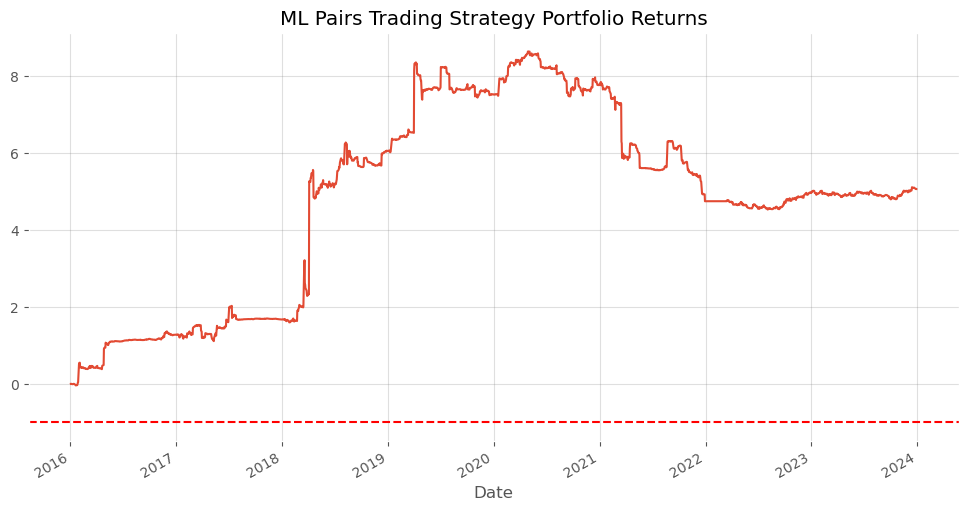

In [16]:
portfolio_strategy_returns = \
(pd.concat(portfolio_returns) + 1).apply(np.log) # convert to log returns

(
    portfolio_strategy_returns
    .cumsum()
).plot(figsize = (12,6))

plt.axhline(-1, ls='--', color = 'r')
plt.title('ML Pairs Trading Strategy Portfolio Returns')

### Sharpe Ratio

$$
(\mu / \sigma) * \sqrt{252}
$$

In [22]:
def sharpe_ratio(data):
    sharpe = \
    (
        np.sqrt(252)
        *
        (data.mean()
         /
         data.std())
    )

    return sharpe

In [23]:
period_1 = portfolio_strategy_returns[trading_dates_periods[1]]
period_2 = portfolio_strategy_returns[trading_dates_periods[2]]
period_3 = portfolio_strategy_returns[trading_dates_periods[3]]
period_4 = portfolio_strategy_returns[trading_dates_periods[4]]

print('Year 2 to 4 Sharpe Ratio:',sharpe_ratio(period_1))
print('Year 4 to 6 Sharpe Ratio:',sharpe_ratio(period_2))
print('Year 6 to 8 Sharpe Ratio:',sharpe_ratio(period_3))
print('Year 8 to 10 Sharpe Ratio:',sharpe_ratio(period_4))

Year 2 to 4 Sharpe Ratio: 1.147970383643739
Year 4 to 6 Sharpe Ratio: 0.8423787614159852
Year 6 to 8 Sharpe Ratio: -0.819082208036011
Year 8 to 10 Sharpe Ratio: 0.565128773202014


In [24]:
sharpe_ratio(portfolio_strategy_returns)

0.3176393390716343

### Drawdown

In [19]:
df = portfolio_strategy_returns.to_frame().rename(columns={0:'strategy'})
df['cumulative_returns'] = \
    (
        df['strategy']
        .cumsum()
        #.apply(np.exp)
    )

df['max_gross_performance'] = \
(
    df['cumulative_returns']
    .cummax()
)

df = df.dropna()
df

,strategy,cumulative_returns,max_gross_performance
Date,,,
2016-01-04,0.000000,0.000000,0.000000
2016-01-05,0.001007,0.001007,0.001007
2016-01-06,-0.001039,-0.000032,0.001007
2016-01-07,-0.003070,-0.003103,0.001007
2016-01-08,-0.003807,-0.006910,0.001007
...,...,...,...
2023-12-22,-0.013141,3.562310,6.334603
2023-12-26,-0.015623,3.546687,6.334603
2023-12-27,0.000363,3.547049,6.334603


<Axes: title={'center': 'ML Pairs Trading Strategy'}, xlabel='Date'>

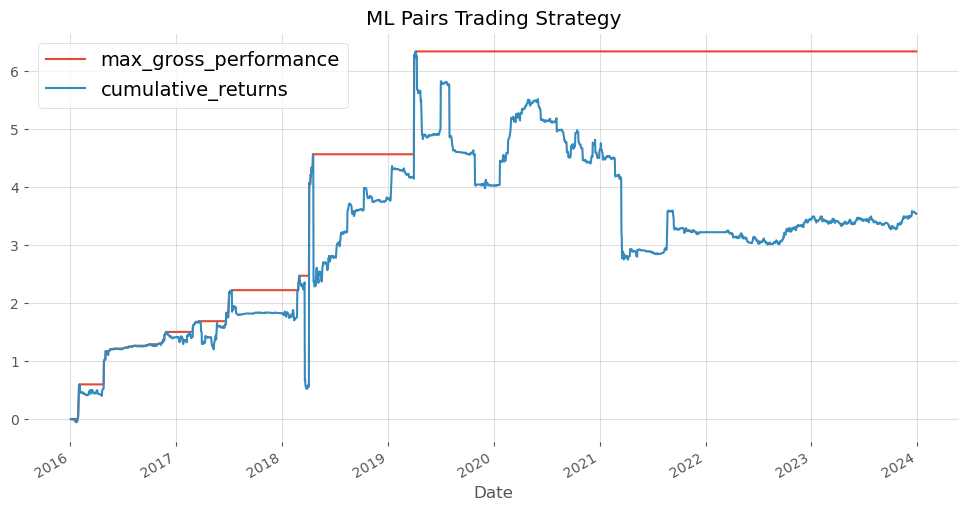

In [20]:
df[['max_gross_performance','cumulative_returns']]\
    .plot(figsize = (12,6),
          title = 'ML Pairs Trading Strategy'
         )


## End of Code

## Code breakdown
Before running this, run the `'Import Data From Local'` section.

### Grouping and Filter Tickers

In [12]:
# To test specific periods
training_period = trading_dates_periods[0]
testing_period = trading_dates_periods[1]

In [13]:
# Grouping
fundamentals_grouping = pd.DataFrame(index = full_data_tickers)

# Check if the median of each ticker crosses median of all tickers in 2 year training data
# Industry
fundamentals_grouping = \
(
    fundamentals_grouping
    .join(exchange_data[exchange_data.symbol.isin(full_data_tickers)]
          [['sector','symbol']].set_index('symbol'),
          how = 'left')
) 

# Group tickers into quintiles
# Median daily mkt cap:
fundamentals_grouping.loc[:, 'mkt_cap'] = \
(
    daily_mkt_cap
    .loc[training_period] # median daily market cap within training period
    .median()
    .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
)

# Median daily notional trading vol
fundamentals_grouping.loc[:, 'prc_vol'] = \
(
    daily_prc_vol
    .loc[training_period] # median daily market cap within training period
    .median()
    .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
)

# Median daily net profit margin
fundamentals_grouping.loc[:, 'npm'] = \
(
    daily_npm
    .loc[training_period] # median daily market cap within training period
    .median()
    .transform(lambda g: pd.qcut(g, q = 5, labels = False) + 1) # group into bins from 1 to 5
)

# Filter specific industries (not used)
# fundamentals_grouping = \
# (
#     fundamentals_grouping
#     [fundamentals_grouping.sector.isin(industry_chosen)]
# )

# Filter liquidity
fundamentals_grouping = \
(
    fundamentals_grouping
    [fundamentals_grouping.prc_vol.isin(prc_vol_quintiles)]
)

# Filter market cap
fundamentals_grouping = \
(
    fundamentals_grouping
    [fundamentals_grouping.mkt_cap.isin(mkt_cap_quintiles)]
)


fundamentals_grouping

,sector,mkt_cap,prc_vol,npm
symbol,,,,
A,Industrials,5,5,4
AAL,Consumer Discretionary,5,5,2
AAPL,Technology,5,5,5
ABBV,Health Care,5,5,5
ABG,Consumer Discretionary,3,4,2
...,...,...,...,...
ZG,Consumer Discretionary,4,5,1
ZION,Finance,4,5,4
ZTS,Health Care,5,5,4


In [14]:
# Price Data for testing co-integration
price_data = \
(
    daily_px.loc[training_period,
                 fundamentals_grouping.index]
)

returns = price_data.pct_change().fillna(0)
returns.shape

(504, 991)

### Find pairs with ML

We first classify stocks into clusters, then within clusters we look for strong mean-reverting pairs.

We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock.

Take these features, add in the fundamental features and use DBSCAN to cluster the stocks.

#### PCA (for picking pairs with most significant impact)
Reason for PCA to so reduce the amplification when market moves against us when we have too many similar pairs.

In [15]:
# PCA
pca = PCA(n_components = n_components, random_state = 20241031)
pca.fit(returns)

pca.components_.T.shape

(991, 50)

In [16]:
# Data have been reduced to the first n_components. Add some fundamental values before doing clustering
pca_fundamentals = \
(
    np.hstack(
        (pca.components_.T,
        fundamentals_grouping['mkt_cap'].values[:, np.newaxis],
        fundamentals_grouping['prc_vol'].values[:, np.newaxis],
        fundamentals_grouping['npm'].values[:, np.newaxis])
    )
)

# scale before applying PCA; owise a feature with large values will dominate the results
pca_fundamentals = preprocessing.StandardScaler().fit_transform(pca_fundamentals)

pca_fundamentals.shape

(991, 53)

#### DBSCAN (cluster grouping)
Group the tickers so that tickers with similar price movements can be paired together.

In [17]:
# DBSCAN to do clusters
clustering = DBSCAN(eps = dbscan_epsilon, min_samples=3)
print(clustering)

clustering.fit(pca_fundamentals)
cluster_labels = clustering.labels_
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clustering.labels_

DBSCAN(eps=1.9, min_samples=3)

Clusters discovered: 9


In [18]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))

Total pairs possible in universe: 490545 


In [19]:
# each ticker with cluster group assigned
clustered_series_all = pd.Series(index = returns.columns, data = clustered.flatten()) # including -1 cluster
clustered_series = pd.Series(index = returns.columns, data = clustered.flatten()) 
clustered_series = clustered_series[clustered_series != -1] # filter away non important componets (-1 cluster remove)

In [20]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts() # Count tickers in each cluster
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)] # remove clusters that is out of limit (i.e. min 2)
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 9
Pairs to evaluate: 500


#### Plot cluster visualisation

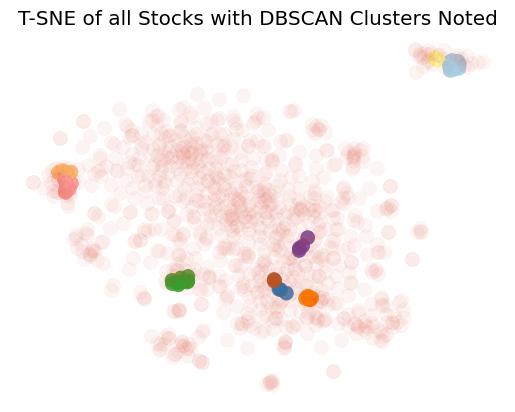

In [21]:
# Cluster Visualization
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(pca_fundamentals)
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(cluster_labels!=-1), 0],
    X_tsne[(cluster_labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=cluster_labels[cluster_labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');


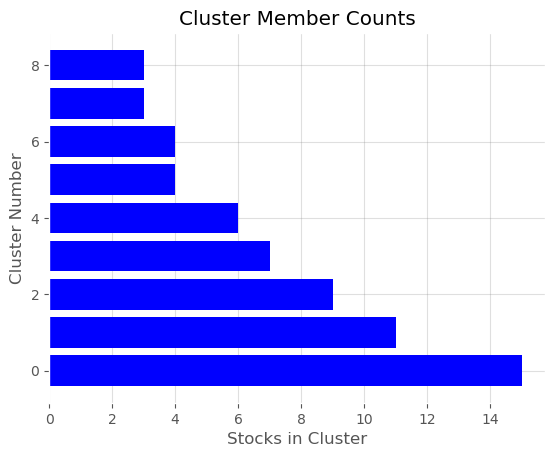

In [28]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts(), color='blue'
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

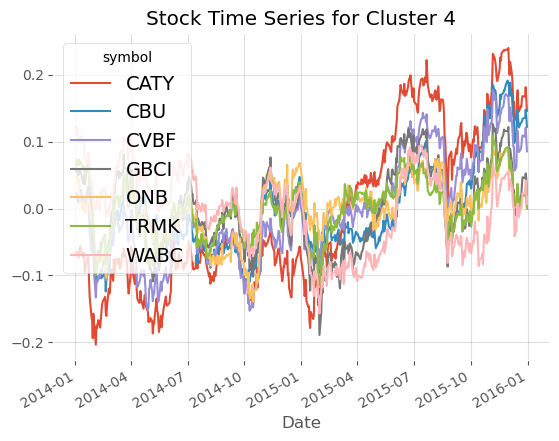

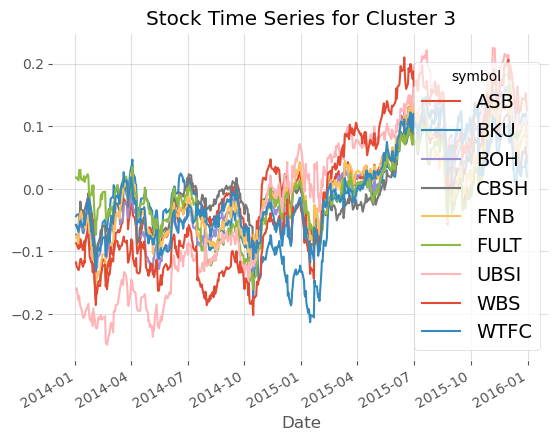

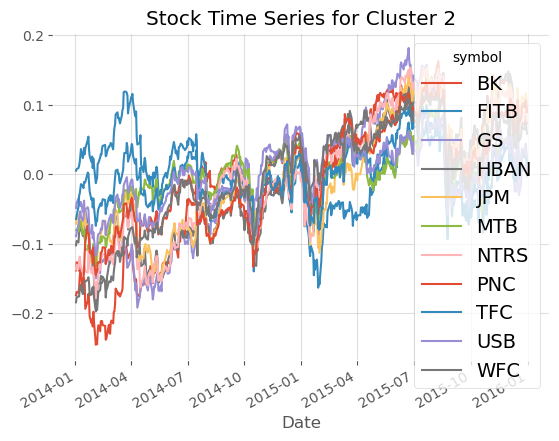

In [27]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
#for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
for clust in cluster_vis_list[-4:-1]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(price_data[tickers].mean())
    data = np.log(price_data[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

### Find coint pairs (Ridge, ADF, Hurst)

#### Test function to apply on pairs price data

In [28]:
def Ridge_ADF_Hurst_coint(data, significance=0.05):
    """
    Identifies cointegrated pairs based on Ridge regression, ADF test, and Hurst exponent.

    Parameters:
    - data: DataFrame of price data with columns as tickers and rows as prices over time.
    - significance: Significance level for the ADF test (default: 0.05).

    Returns:
    - pairs: Dictionary with keys as cointegrated pairs of tickers and values as a tuple of:
        - hedge ratio,
        - mean of the spread,
        - standard deviation of the spread.
    """
    n = data.shape[1]
    keys = data.columns  # Column names (tickers) of the price data
    pairs = {}  # Dictionary to store cointegrated pairs

    for i in range(n):
        for j in range(i + 1, n):
            x = data[keys[i]]
            y = data[keys[j]]
            
            # Add constant to predictor for Ridge regression
            X_with_const = sm.add_constant(x)
            ridgereg = Ridge()
            ridgereg.fit(X_with_const, y)

            # Retrieve the constant and coefficient from Ridge regression
            intercept = ridgereg.intercept_
            b = ridgereg.coef_[1]

            # Calculate spread with intercept included
            spread = y - (b * x)

            # Hurst Exponent (test for mean reversion)
            H = compute_Hc(spread)[0]
            
            # ADF (test for stationarity)
            adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
            pvalue = adf[1]

            # Check for cointegration: ADF significance and Hurst exponent < 0.5
            if pvalue < significance and H < 0.5:
                pairs[(keys[i], keys[j])] = (b, spread.mean(), spread.std())
                pairs.update({(keys[i], keys[j]):
                                   (b, # hedge ratio
                                    spread.mean(),
                                    spread.std(),
                                    intercept)
                                  })

    return pairs


In [29]:
dict_pairs = {} # store all the coint pairs based on training data
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    coint_pairs = \
    (
        Ridge_ADF_Hurst_coint(price_data[tickers], pvalue_threshold)
    )
    dict_pairs.update(coint_pairs)

print('Total pairs found: ', len(dict_pairs))
print('Unique tickers: ', len(np.unique(list(dict_pairs.keys()))))

Total pairs found:  85
Unique tickers:  50


#### Pick random pair to plot Hurst Exponent (to test for mean reversion of spread)

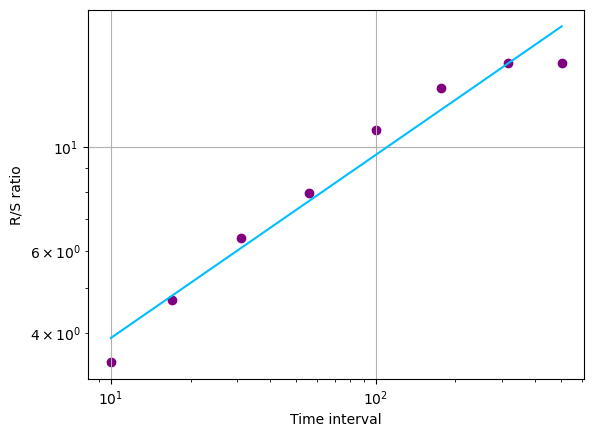

H=0.3912, c=1.5851


In [30]:
# HURST
import random
rand_ticker = random.choice(list(dict_pairs.keys()))

x = price_data[rand_ticker[0]]
y = price_data[rand_ticker[1]]

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

x = x[rand_ticker[0]] # remove constant

b = results.params[rand_ticker[0]]
spread = y - b*x

# Evaluate Hurst equation
H, c, data = compute_Hc(spread)#, kind='price', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

### Test coint pairs trading performance

#### Pull coint pairs from training data

In [32]:
# Dataframe to hold coint pairs in 
df_coint_pairs = pd.DataFrame(data = dict_pairs.values(),
                              index = dict_pairs.keys(),
                              columns = ['hedge_ratio', 'spread_mean', 'spread_std', 'intercept'])
df_coint_pairs

hedge_ratio  spread_mean  spread_std   intercept
AEE ES      1.253375    -2.830790    0.968670   -2.830790
    SO      0.797156     5.730371    0.706764    5.730371
    WEC     1.198088    -4.557934    0.914581   -4.557934
AEP D       0.624796    22.477232    1.046534   22.477232
    DTE     1.255870     2.881588    0.804057    2.881588
...              ...          ...         ...         ...
NWE POR     0.659657     1.535851    0.498999    1.535851
PNW POR     0.569296     4.082212    0.501980    4.082212
DHR EMR    -1.357145    91.227467    3.009998   91.227467
    HON     1.495114    25.486390    2.127358   25.486390
EMR HON    -0.606291   103.707419    3.659179  103.707419

[85 rows x 4 columns]

#### Testing pairs trading performance

In [34]:
# Collecting z-spread data in test period
price_data = \
(
    daily_px.loc[testing_period]
)

# Current spread
df_spread = pd.DataFrame(index = testing_period,
                         columns = dict_pairs.keys())

# Compute spread data for current period
for pair in df_spread.columns:
    x_price = price_data[pair[0]]
    y_price = price_data[pair[1]]

    pair_b = df_coint_pairs.loc[pair]['hedge_ratio']
    spread_mean = df_coint_pairs.loc[pair]['spread_mean']
    spread_std = df_coint_pairs.loc[pair]['spread_std']

    pair_spread = y_price - (pair_b * x_price)
    pair_zspread = (pair_spread - spread_mean)/spread_std

    df_spread.loc[testing_period, pair] = pair_zspread

In [35]:
# Collecting dataframe returns of each pair
df_returns = pd.DataFrame(index = testing_period,
                          columns = dict_pairs.keys())

for pair in df_returns.columns:
    x_price = price_data[pair[0]]
    y_price = price_data[pair[1]]

    pair_b = df_coint_pairs.loc[pair]['hedge_ratio']
    pair_value = y_price - (x_price * pair_b)

    df_returns.loc[testing_period, pair] = pair_value

df_returns = df_returns.pct_change().fillna(0)

df_returns

C:\Users\User\AppData\Local\Temp\ipykernel_8756\194364074.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_returns.pct_change().fillna(0)


AEE                           AEP                      \
                  ES        SO       WEC         D       DTE        ED   
Date                                                                     
2016-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-05  0.046781 -0.013987  0.021403  0.009096  0.229049  0.012120   
2016-01-06  0.061675 -0.027514  0.082460  0.009475 -0.742056 -0.009213   
2016-01-07  0.084621 -0.050559  0.007421  0.016938  0.193952 -0.255024   
2016-01-08 -0.024425 -0.005983 -0.029990  0.036129 -0.804660 -0.213480   
...              ...       ...       ...       ...       ...       ...   
2017-12-22  0.001414  1.193854  0.026813 -0.004727  0.062897 -0.022195   
2017-12-26 -0.007006  0.048198 -0.012781  0.010330  0.029544 -0.079771   
2017-12-27 -0.004943  0.141934  0.001065  0.005139  0.026746 -0.059614   
2017-12-28  0.012526  0.057310  0.004028  0.004306  0.030360  0.022761   
2017-12-29 -0.035078  0.017445 -0.017189  0.001331 -0.003930  0.017089   

                                                         CMS            \
                 EIX        ES       NEE        SO         D       NEE   
Date                                                                     
2016-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-05  0.053987  0.392581  0.015218  0.003094  0.009089  0.012525   
2016-01-06  0.060739 -0.437767 -0.028174 -0.011273  0.009379 -0.010037   
2016-01-07 -0.045385  2.597767  0.063070  0.001716 -0.003103  0.001887   
2016-01-08 -0.008909 -0.642597  0.025136 -0.026714  0.025764  0.013616   
...              ...       ...       ...       ...       ...       ...   
2017-12-22 -0.078018 -0.182974  0.003387 -0.186204 -0.006127 -0.001216   
2017-12-26  0.016288 -0.080112  0.006649 -0.012718  0.006540  0.004903   
2017-12-27 -0.002346 -0.182386  0.017421 -0.037336  0.000675  0.008201   
2017-12-28  0.014407 -0.038840  0.009038 -0.004437  0.006074  0.009974   
2017-12-29  0.024724 -0.198286 -0.000911 -0.036629  0.001259 -0.000115   

                             D                 DTE                 DUK  \
                 XEL       DUK       EIX       EIX        SO       SRE   
Date                                                                     
2016-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-05  0.023119  0.013828  0.021911  0.067633 -0.002887  0.049312   
2016-01-06  0.063414  0.020471  0.026355  0.006969  0.014910 -0.224746   
2016-01-07 -0.008570  0.035402  0.009041 -0.042995 -0.000837 -0.495690   
2016-01-08 -0.062185  0.072687  0.037213 -0.027439 -0.016937  0.235852   
...              ...       ...       ...       ...       ...       ...   
2017-12-22 -0.027899 -0.006451 -0.041103 -0.044619 -0.654827  0.274782   
2017-12-26  0.005798  0.018318  0.019832  0.020616 -0.301506  0.043581   
2017-12-27 -0.001462  0.002553  0.002278  0.005680 -0.609441 -0.075179   
2017-12-28  0.016765  0.022753  0.008493  0.019196 -0.889321  0.008834   
2017-12-29  0.013908 -0.005526  0.012930  0.017044 -6.506302 -0.043448   

                  ED                                                ES  \
                  ES       NEE       PEG       WEC       XEL       NEE   
Date                                                                     
2016-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-05  0.016755  0.012938 -0.005945  0.032722  0.044858  0.011212   
2016-01-06 -0.012746 -0.017137 -0.087484 -0.060075  0.099841 -0.018540   
2016-01-07 -0.086096 -0.001341 -0.011519 -0.064687 -0.050305  0.035186   
2016-01-08 -0.114475 -0.006778 -0.152809 -0.143068 -0.337499  0.034351   
...              ...       ...       ...       ...       ...       ...   
2017-12-22  0.090858  0.001443  0.010740  0.023609 -0.033911 -0.008089   
2017-12-26 -0.007534  0.000169  0.022725  0.005457 -0.038066  0.000991   
2017-12-27  0.052042  0.011916 -0.024002  0.034569  0.027329  0.007187   
2017-12-28  0.0246

In [36]:
# Define trading position in each pairs

df_position = pd.DataFrame(index = testing_period,
                           columns = dict_pairs.keys())

# stop loss
df_position.loc[:, :] = \
(
    np
    .where(abs(df_spread) > stoploss_sd, # 2.5
           0, np.nan)
)

# Short Y, long bx
df_position.loc[:, :] = \
(
    np
    .where((df_spread > entry_sd) & (df_spread < stoploss_sd), # between 1.5 to 2.5
           -1, df_position)
)

# Long y, short bx
df_position.loc[:, :] = \
(
    np
    .where((df_spread < entry_sd * -1) & (df_spread > stoploss_sd * -1), # between -1.5 and -2.5
           1, df_position)
)



# Take profit (short y, long bx)
df_position.loc[:, :] = \
(
    np
    .where((df_spread < exit_sd) & # z-score spread reach below 0.5
           (df_spread < df_spread.shift(1)) & # z-score moving down
           (df_position.shift(1) == -1), # close position only when is open
           0, df_position)
)

# Take profit (long y, short bx)
df_position.loc[:, :] = \
(
    np
    .where((df_spread > exit_sd * -1) & # z-score spread reach above 0.5
           (df_spread > df_spread.shift(1)) & # z-score moving up
           (df_position.shift(1) == 1), # close position only when is open
           0, df_position)
)

df_position = df_position.ffill().fillna(0)
df_position

C:\Users\User\AppData\Local\Temp\ipykernel_8756\1907217142.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_position = df_position.ffill().fillna(0)


AEE            AEP                                CMS            \
             ES   SO  WEC    D  DTE   ED  EIX   ES  NEE   SO    D  NEE  XEL   
Date                                                                          
2016-01-04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0   
2016-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0   
2016-01-06  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0 -1.0   
2016-01-07  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 -1.0 -1.0  1.0  0.0 -1.0   
2016-01-08  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 -1.0 -1.0  1.0 -1.0 -1.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0   
2017-12-26  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-27  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2017-12-28  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2017-12-29  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

              D       DTE       DUK   ED                       ES       ...  \
            DUK  EIX  EIX   SO  SRE   ES  NEE  PEG  WEC  XEL  NEE   SO  ...   
Date                                                                    ...   
2016-01-04  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  ...   
2016-01-05  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-06  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-07  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-08  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-26  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-27  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-28  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-29  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   

            BOH CBSH  FNB FULT CATY                      CBU      CVBF       \
           WTFC WTFC FULT  VLY CVBF GBCI  ONB TRMK WABC  ONB TRMK  ONB TRMK   
Date                                                                          
2016-01-04  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
2016-01-05  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
2016-01-06  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
2016-01-07  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
2016-01-08  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-26  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-27  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-28  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           GBCI       ONB  KMB   KO  IDA  NWE       PNW  DHR       EMR  
            ONB TRMK TRMK   KO  PEP  NWE  PNW  POR  POR  EMR  HON  HON  
Date                                                                    
2016-01-04  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-05  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-06  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-07  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  
2016-01-08  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2017-12-22 -1.0  0.0  0.0  0.0 -1.

In [37]:
df_spread #* df_spread.shift(1)

AEE                            AEP                      \
                  ES         SO       WEC         D       DTE        ED   
Date                                                                      
2016-01-04 -0.336535   1.283064 -0.048442 -2.685421 -2.970754 -0.040903   
2016-01-05  -0.48899   1.151716 -0.156141 -2.514494 -2.830334 -0.075731   
2016-01-06 -0.699386   0.896945 -0.579967 -2.334808 -3.389454 -0.048937   
2016-01-07 -1.005859   0.441668 -0.621253 -2.010565 -3.351759  0.685936   
2016-01-08 -0.909913   0.390512 -0.453161 -1.307226  -3.53848  1.144216   
...              ...        ...       ...       ...       ...       ...   
2017-12-22 -8.349466 -10.829553 -6.045747  0.984778  5.566301  1.052474   
2017-12-26 -8.270498 -10.960732 -5.904782  1.216812  5.836633   1.19448   
2017-12-27 -8.215169 -11.365647 -5.916374   1.33345  6.088592  1.292138   
2017-12-28 -8.354675 -11.552348  -5.96028  1.431672  6.382247  1.257074   
2017-12-29 -7.959097 -11.612438  -5.77216  1.462175  6.343078  1.230148   

                                                           CMS             \
                  EIX        ES        NEE        SO         D        NEE   
Date                                                                        
2016-01-04  -3.145354  -0.30301   1.215031  1.689774 -1.931031    1.19781   
2016-01-05  -3.519036 -0.250139   1.393458   1.73715 -1.739823   1.447542   
2016-01-06  -3.962146  -0.33224    1.05809  1.563972 -1.540713     1.2449   
2016-01-07  -3.610939 -0.058319   1.787675  1.590031 -1.607197   1.282618   
2016-01-08  -3.545125 -0.302099   2.096787  1.183578 -1.056834   1.555256   
...               ...       ...        ...       ...       ...        ...   
2017-12-22 -13.350507 -2.687542  20.198312 -7.443959  2.344331  20.151555   
2017-12-26 -13.629475 -2.507301  20.402476 -7.522564  2.509876  20.342264   
2017-12-27 -13.588634 -2.129832  20.940994 -7.750394  2.527062  20.662797   
2017-12-28 -13.838806 -2.064108  21.225242 -7.776457  2.681911  21.055827   
2017-12-29 -14.274328 -1.741612   21.19633 -7.990669  2.714197  21.051268   

                              D                  DTE                  DUK  \
                  XEL       DUK       EIX        EIX         SO       SRE   
Date                                                                        
2016-01-04   0.919955  0.560126  0.979193   -1.22225   3.959817 -2.289469   
2016-01-05   1.296882  0.450794  0.662601  -1.775964   3.913679 -2.116794   
2016-01-06   2.354665  0.286704  0.273457  -1.836882   4.151248 -2.942596   
2016-01-07   2.202653 -0.002875  0.136448  -1.458449   4.137712 -4.354606   
2016-01-08   1.109036 -0.618482 -0.432601  -1.227319   3.864048  -4.01579   
...               ...       ...       ...        ...        ...       ...   
2017-12-22   9.743636 -1.729485 -6.099301 -20.158409 -11.062704 -3.258878   
2017-12-26   9.889319  -1.91625 -6.526224 -20.717584 -11.351389 -3.148518   
2017-12-27   9.852382 -1.942758 -6.576228 -20.874834 -11.758978  -3.34719   
2017-12-28  10.275479 -2.179599 -6.763101 -21.409234  -11.99127 -3.325599   
2017-12-29  10.632341 -2.120768  -7.05003 -21.892833 -12.179364 -3.432724   

                  ED                                                  ES  \
                  ES        NEE       PEG       WEC       XEL        NEE   
Date                                                                       
2016-01-04  0.099255   1.173584 -1.466622  0.374959  0.810625   1.418811   
2016-01-05  0.201907   1.345106   -1.4865  0.524437  0.937856   1.552037   
2016-01-06  0.122508   1.114976 -1.777297  0.241025  1.233736   1.329274   
2016-01-07 -0.406973    1.09728 -1.812236  -0.04581  1.069772   1.744204   
2016-01-08 -1.050366   1.007943 -2.270397 -0.639169  0.025065   2.163547   
...              ...        ...       ...       ...       ...        ...   
2017-12-22 -1.720454  14.527013  0.140325  0.502892  2.828823   19.80309   
2017-12-26 -1.752902  14.531518  0.252832  0.528

In [38]:
df_position

AEE            AEP                                CMS            \
             ES   SO  WEC    D  DTE   ED  EIX   ES  NEE   SO    D  NEE  XEL   
Date                                                                          
2016-01-04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0   
2016-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0   
2016-01-06  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0 -1.0   
2016-01-07  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 -1.0 -1.0  1.0  0.0 -1.0   
2016-01-08  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 -1.0 -1.0  1.0 -1.0 -1.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0   
2017-12-26  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-27  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2017-12-28  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2017-12-29  0.0  0.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

              D       DTE       DUK   ED                       ES       ...  \
            DUK  EIX  EIX   SO  SRE   ES  NEE  PEG  WEC  XEL  NEE   SO  ...   
Date                                                                    ...   
2016-01-04  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  ...   
2016-01-05  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-06  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-07  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
2016-01-08  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0 -1.0  ...   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-26  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-27  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-28  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   
2017-12-29  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0 -1.0  0.0  0.0  0.0  ...   

            BOH CBSH  FNB FULT CATY                      CBU      CVBF       \
           WTFC WTFC FULT  VLY CVBF GBCI  ONB TRMK WABC  ONB TRMK  ONB TRMK   
Date                                                                          
2016-01-04  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
2016-01-05  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
2016-01-06  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
2016-01-07  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
2016-01-08  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-12-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-26  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-27  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-28  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017-12-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           GBCI       ONB  KMB   KO  IDA  NWE       PNW  DHR       EMR  
            ONB TRMK TRMK   KO  PEP  NWE  PNW  POR  POR  EMR  HON  HON  
Date                                                                    
2016-01-04  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-05  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-06  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-07  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  
2016-01-08  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2017-12-22 -1.0  0.0  0.0  0.0 -1.

In [39]:
df_strategy = df_returns * df_position.shift(1).fillna(0)
df_strategy

AEE                 AEP                                          \
             ES   SO  WEC         D  DTE        ED  EIX        ES       NEE   
Date                                                                          
2016-01-04  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
2016-01-05  0.0 -0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
2016-01-06  0.0 -0.0  0.0  0.000000 -0.0 -0.000000  0.0 -0.000000 -0.000000   
2016-01-07  0.0 -0.0  0.0  0.016938  0.0 -0.000000 -0.0  0.000000  0.000000   
2016-01-08 -0.0 -0.0 -0.0  0.036129 -0.0 -0.000000 -0.0 -0.000000 -0.025136   
...         ...  ...  ...       ...  ...       ...  ...       ...       ...   
2017-12-22  0.0  0.0  0.0  0.004727  0.0  0.022195 -0.0 -0.000000  0.000000   
2017-12-26 -0.0  0.0 -0.0 -0.010330  0.0  0.079771  0.0 -0.000000  0.000000   
2017-12-27 -0.0  0.0  0.0 -0.005139  0.0  0.059614 -0.0 -0.000000  0.000000   
2017-12-28  0.0  0.0  0.0 -0.004306  0.0 -0.022761  0.0 -0.038840  0.000000   
2017-12-29 -0.0  0.0 -0.0 -0.001331 -0.0 -0.017089  0.0 -0.198286 -0.000000   

                           CMS                        D            DTE       \
                  SO         D  NEE       XEL       DUK  EIX       EIX   SO   
Date                                                                          
2016-01-04  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
2016-01-05 -0.003094  0.009089  0.0  0.000000  0.000000  0.0  0.000000 -0.0   
2016-01-06  0.011273  0.009379 -0.0  0.000000  0.000000  0.0  0.006969  0.0   
2016-01-07 -0.001716 -0.003103  0.0  0.008570  0.000000  0.0 -0.042995 -0.0   
2016-01-08  0.026714  0.025764  0.0  0.062185  0.000000  0.0 -0.027439 -0.0   
...              ...       ...  ...       ...       ...  ...       ...  ...   
2017-12-22 -0.000000 -0.000000 -0.0 -0.000000 -0.006451 -0.0 -0.000000 -0.0   
2017-12-26 -0.000000 -0.006540  0.0  0.000000  0.018318  0.0  0.000000 -0.0   
2017-12-27 -0.000000  0.000000  0.0 -0.000000  0.002553  0.0  0.000000 -0.0   
2017-12-28 -0.000000  0.000000  0.0  0.000000  0.022753  0.0  0.000000 -0.0   
2017-12-29 -0.000000  0.000000 -0.0  0.000000 -0.005526  0.0  0.000000 -0.0   

                 DUK        ED                                      ES  \
                 SRE        ES  NEE       PEG       WEC  XEL       NEE   
Date                                                                     
2016-01-04  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
2016-01-05  0.049312  0.000000  0.0 -0.000000  0.000000  0.0  0.000000   
2016-01-06 -0.224746 -0.000000 -0.0 -0.000000 -0.000000  0.0  0.018540   
2016-01-07 -0.000000 -0.000000 -0.0 -0.011519 -0.000000 -0.0 -0.035186   
2016-01-08  0.000000 -0.000000 -0.0 -0.152809 -0.000000 -0.0 -0.034351   
...              ...       ...  ...       ...       ...  ...       ...   
2017-12-22  0.000000  0.090858  0.0  0.010740 -0.023609 -0.0 -0.000000   
2017-12-26  0.000000 -0.007534  0.0  0.022725 -0.005457 -0.0  0.000000   
2017-12-27 -0.000000  0.052042  0.0 -0.024002 -0.034569  0.0  0.000000   
2017-12-28  0.000000  0.024666  0.0  0.014451 -0.042269  0.0  0.000000   
2017-12-29 -0.000000  0.060621 -0.0  0.030210 -0.016466  0.0 -0.000000   

                      ...       BOH CBSH  FNB      FULT CATY            \
                  SO  ...      WTFC WTFC FULT       VLY CVBF      GBCI   
Date                  ...                                                
2016-01-04  0.000000  ...  0.000000  0.0  0.0  0.000000  0.0  0.000000   
2016-01-05 -0.000975  ...  0.071121 -0.0  0.0 -0.000000  0.0  0.000000   
2016-01-06  0.005085  ... -0.026831 -0.0  0.0 -0.000000 -0.0 -0.000000   
2016-01-07  0.014593  ...  0.014737 -0.0 -0.0 -0.000000 -0.0 -0.000000   
2016-01-08  0.010780  ... -0.089088  0.0  0.0 -0.016903  0.0 -0.013999   
...              ...  ...       ...  ...  ...       ...  ...       ...   
2017-12-22 -0.142797  ... -0.000000 -0.0 -0.0  0.000000  0.0 -0.000000   
2017-12-26 -0.000000 

<Axes: xlabel='Date'>

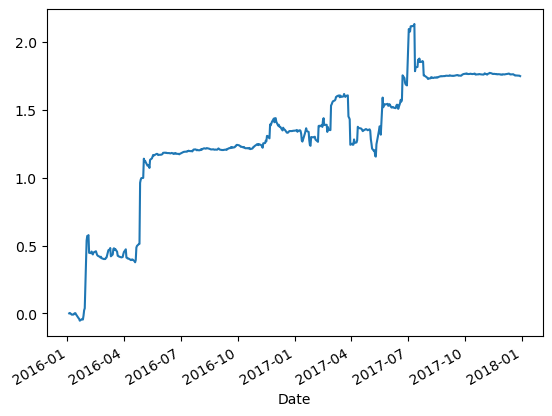

In [41]:
# Portfolio returns
# Assuming we set equal weight for each coint pairs for each period
porfolio_returns = df_strategy.mean(axis=1)
(porfolio_returns+1).apply(np.log).cumsum().plot()
#pd.concat([df_porfolio_returns, df_porfolio_returns])

### Cointegration
Before using pairs trading, we need to know the cointegration. Cointegration is a statistical property of time series (that is a series of random variables)

- Correlation specify the co-movement of return, it is a short-term relationship

- Cointegration specify co-movement of price, it is a long-term relationship

Generally speaking, the weak stationary process means the mean and the autocovariance do not vary over time. For example, white noise $\epsilon_t$ is an example of stationary time series because $E(\epsilon_t)=0$ and $Var(\epsilon_t)=\sigma^2$. 

If two series {$x_t$} and {$y_t$} are not stationary but their linear combination $ u_t = \beta x_t - y_t$ is a stationary process, then we say {xt} and {yt} are cointegrated. Here we take the first-order difference of x and y, then we say their relationship is first-order cointegration. Most of the financial time series are integrated of order 1.

In general, we use Augmented Dickey-Fuller test to test cointegration.

### Step 1:  Find two likely cointegrated stocks
Two stocks we choose here is AAPL and AMD. They are of the same industry.


In [4]:
# Tech Stocks
#tickers = ['AAPL', 'AMD']

# Parameters
start_date = '2014-01-01'
end_date = '2024-08-31'

# Download
data = (
    yf
    .download(tickers,
              start = start_date,
              end = end_date)
)
data

[*********************100%%**********************]  4706 of 4706 completed

14 Failed downloads:
['BIOA', 'KAPA', 'MBX', 'BCAX', 'ZBIO', 'LGCY', 'HCWC', 'GRDN', 'BKV', 'IBO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1725076800")
['ECC           ', 'ETX           ']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['WTMAR', 'SQFTW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Price        Adj Close                                                      \
Ticker               A         AA  AADI        AAL      AAME    AAN   AAOI   
Date                                                                         
2014-01-02   37.446896  24.432325   NaN  23.907927  3.808644    NaN  14.63   
2014-01-03   37.919888  24.525137   NaN  25.020361  3.894769    NaN  14.35   
2014-01-06   37.733356  24.432325   NaN  25.482304  3.856491    NaN  14.33   
2014-01-07   38.272972  24.455534   NaN  25.369167  3.866060    NaN  14.74   
2014-01-08   38.899185  25.128407   NaN  26.047949  3.837353    NaN  14.66   
...                ...        ...   ...        ...       ...    ...    ...   
2024-08-26  140.490005  34.560001  1.75  10.210000  1.600000  10.08   9.62   
2024-08-27  141.100006  34.299999  1.68  10.170000  1.600000  10.07   9.18   
2024-08-28  141.059998  32.090000  1.68  10.150000  1.560000  10.09   9.12   
2024-08-29  142.529999  32.470001  1.75  10.390000  1.560000  10.09  10.30   
2024-08-30  142.919998  32.099998  1.81  10.620000  1.600000  10.09  11.35   

Price                                         ... Volume                   \
Ticker           AAON        AAPL        AAT  ...   ZTEK      ZTS    ZUMZ   
Date                                          ...                           
2014-01-02  13.074337   17.253254  25.161169  ...  10300  2576100  328400   
2014-01-03  13.070211   16.874277  25.547523  ...   7400  2524900  330700   
2014-01-06  12.859802   16.966303  25.467033  ...   2500  2763200  379200   
2014-01-07  13.045458   16.844952  25.756798  ...  34000  2338200  382500   
2014-01-08  13.103218   16.951632  25.314100  ...  21400  3965900  609400   
...               ...         ...        ...  ...    ...      ...     ...   
2024-08-26  93.764183  227.179993  26.549999  ...  42000  1015900  304700   
2024-08-27  93.104790  228.029999  26.900000  ...   7400  1423900  743700   
2024-08-28  92.685165  226.490005  26.959999  ...  27700  1485400  214700   
2024-08-29  93.614319  229.789993  27.070000  ...  18000  1359900  227300   
2024-08-30  95.422668  229.000000  27.250000  ...  15200  2328500  173000   

Price                                                                          
Ticker            ZUO      ZVIA      ZVRA     ZVSA     ZWS       ZYME    ZYXI  
Date                                                                           
2014-01-02        NaN       NaN       NaN      NaN  201200        NaN    6600  
2014-01-03        NaN       NaN       NaN      NaN  146700        NaN    7810  
2014-01-06        NaN       NaN       NaN      NaN  724300        NaN   11880  
2014-01-07        NaN       NaN       NaN      NaN  308500        NaN    4400  
2014-01-08        NaN       NaN       NaN      NaN  222100        NaN    6490  
...               ...       ...       ...      ...     ...        ...     ...  
2024-08-26  1571000.0  197800.0  301700.0  49100.0  552500   737700.0  131500  
2024-08-27   945700.0   54000.0  263300.0  44700.0  664100   450000.0   56000  
2024-08-28   892800.0  182200.0  528100.0  26000.0  386400   764400.0   75400  
2024-08-29   996400.0   93500.0  490300.0  10300.0  523500  1054200.0   75000  
2024-08-30   915700.0   80700.0  436200.0  29000.0  531400   375100.0  199800  

[2684 rows x 28236 columns]

In [21]:
# Download Volume
data_vol = (
    yf
    .download(tickers,
              start = start_date,
              end = end_date)['Volume']
)

data_vol.mean()

[*********************100%%**********************]  4706 of 4706 completed

14 Failed downloads:
['ZBIO', 'HCWC', 'BCAX', 'BKV', 'LGCY', 'KAPA', 'GRDN', 'MBX', 'BIOA', 'IBO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1725076800")
['ETX           ', 'ECC           ']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['SQFTW', 'WTMAR']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Ticker
A       2.103868e+06
AA      6.746669e+06
AADI    1.390067e+05
AAL     2.301118e+07
AAME    7.102086e+04
            ...     
ZVRA    2.713383e+05
ZVSA    6.752632e+04
ZWS     8.397021e+05
ZYME    4.889675e+05
ZYXI    2.246967e+05
Length: 4706, dtype: float64

In [3]:
price = data
lp = np.log(price)

In [4]:
for tick in tickers:
    #max = price[tick].max()
    #min = price[tick].min()
    #price[tick+'_NORM'] = price[tick].apply(lambda x: (x - min) / (max - min))
    base = price[tick][0]
    price[tick+'_NORM'] = price[tick].apply(lambda x: x / base * 100)
price_norm = price[[tick+'_NORM' for tick in tickers]]

C:\Users\User\AppData\Local\Temp\ipykernel_6416\4025387791.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base = price[tick][0]
C:\Users\User\AppData\Local\Temp\ipykernel_6416\4025387791.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base = price[tick][0]


<Axes: xlabel='Date'>

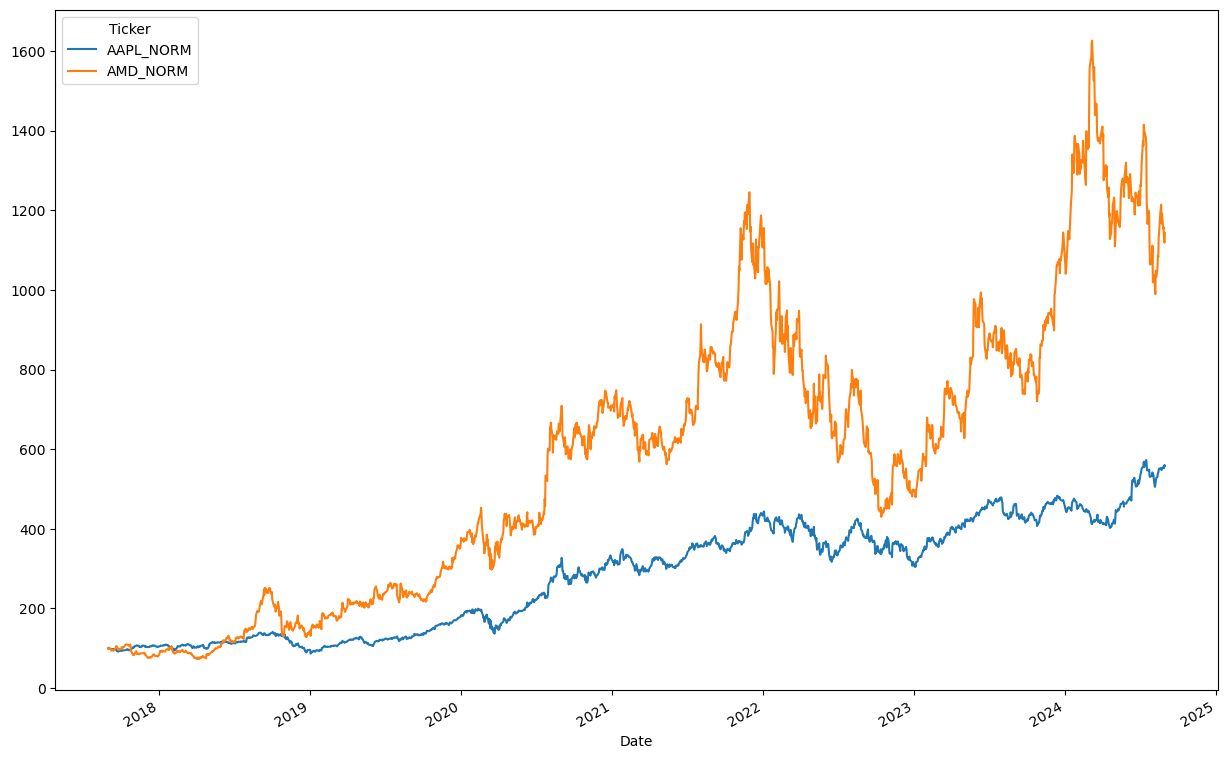

In [5]:
#price.plot(figsize = (15,10))
price_norm.plot(figsize = (15,10))

### Step 2: Estimate Spreads
If we have two stocks, X & Y, that are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. Next step we will estimate the spread series.

In [6]:
def get_spread(x_ticker, y_ticker):
    # Get log price series
    x = lp[x_ticker]
    y = lp[y_ticker]

    # Regression
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    x = x[x_ticker]
    
    b = results.params[x_ticker]
    spread = y - b*x
    #spread.plot(figsize=(12,6))
    #plt.show()
    return spread

Text(0, 0.5, 'spread')

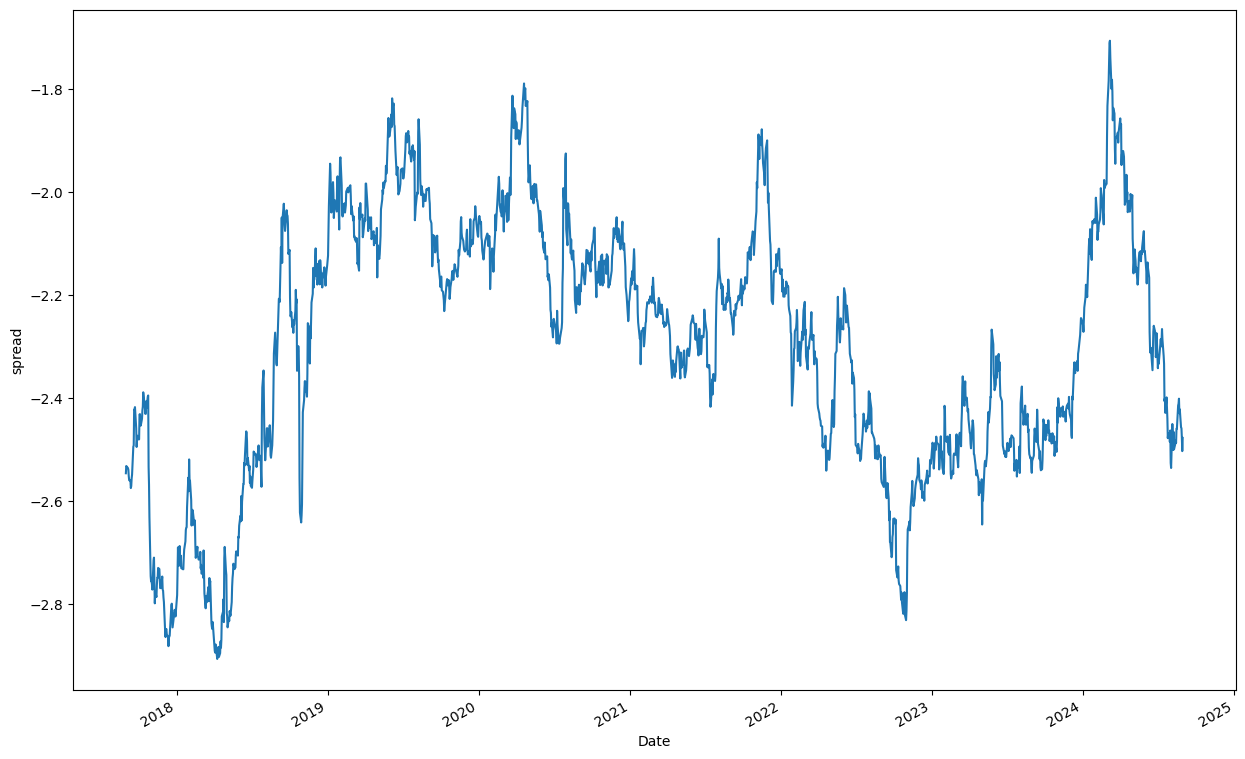

In [7]:
spread = get_spread(tickers[0], tickers[1])
# plot the spread series
spread.plot(figsize =(15,10))
plt.ylabel('spread')

### Step 3: Check Stationarity
From the above plot, the first order difference $Spread_t=log(y_t) -\beta log(x_t)-\alpha$ seems to be stationary and mean-reverting. Next we will check if it is stationary. We use the ADF test to check the stationarity of the spread series.

In [8]:
# check if the spread (time series) is stationary
# unit root means time series has a trend (i.e. not stationary)
# H0 = time series has unit root, HA = time series is stationary

adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

# ADF test statistics:
# 1%, 5% and 10% significant level (i.e. 99%, 95% and 90% Critical Interval)
# p-value = for testing if pair are co-integrated (i.e. less than 0.05, reject H0)

ADF test statistic: -2.62
	1%: -3.434
	5%: -2.863
	10%: -2.568
p-value: 0.088


Running the example prints the test statistic value of -3.45. The more negative this statistic, the more likely we are to reject the null hypothesis (there is a unit root).

As part of the output, we get a table to help determine the ADF statistic. We can see that our statistic value of -3.25 is more than the value of -3.436 at 1%. The p-value 0.017 is more than 0.05.

This suggests that we can reject the null hypothesis with a significance level of less than 5%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### 4. Pairwise Loop to get cointegration pairs

In [9]:
# Parameters

# Tickers
# Tech Stocks
#tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY','NVDA']
tickers = ['EUR=X', 'GBP=X', 'CHF=X', 'JPY=X', 'AUD=X', 'NZD=X', 'CAD=X']

# Crude, Heating oil, Natural Gas
#tickers = ['CL=F','HO=F','NG=F','RB=F','BZ=F']

# Date
start_date = '2017-08-31'
end_date = '2024-08-31'

# Download
data = (
    yf
    .download(tickers,
              start = start_date,
              end = end_date)['Close']
).dropna()
data

[*********************100%%**********************]  7 of 7 completed


Ticker,AUD=X,CAD=X,CHF=X,EUR=X,GBP=X,JPY=X,NZD=X
Date,,,,,,,
2017-08-31,1.264700,1.26274,0.96370,0.84080,0.77396,110.459999,1.38814
2017-09-01,1.259500,1.24720,0.95940,0.83960,0.77270,110.128998,1.39293
2017-09-04,1.255540,1.23785,0.96083,0.84155,0.77130,109.794998,1.39513
2017-09-05,1.258600,1.24129,0.95882,0.84080,0.77375,109.809998,1.39634
2017-09-06,1.248910,1.23681,0.95340,0.83864,0.76680,108.601997,1.37758
...,...,...,...,...,...,...,...
2024-08-26,1.473230,1.35080,0.84732,0.89382,0.75685,144.000000,1.60666
2024-08-27,1.476470,1.34821,0.84710,0.89568,0.75805,144.516006,1.61147
2024-08-28,1.473210,1.34477,0.84172,0.89462,0.75429,143.975006,1.60151


In [10]:
# LOOP THRU TICKER PAIRS TO IDENTIFY P-VALUES less than 0.05
n = data.shape[1] # number of columns

# Tickers
keys = data.keys()

# Outputs
pairs = []

# For Loop to pull ticker pairs
for i in range(n):
    for j in range(i+1, n):
        # identify tickers
        tickers_pair = [keys[i], keys[j]]
        #print(tickers)
        
        # Pull price and log price
        price = data[tickers_pair]
        #price[price < 0 ] = 0.000001
        lp = np.log(price)

        # Pull log price series to get spread
        x = lp[tickers_pair[0]]
        y = lp[tickers_pair[1]]

        # Regression
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        x = x[tickers_pair[0]] # remove constant
        
        b = results.params[tickers_pair[0]] # beta
        spread = y - b*x

        # ADF test
        adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
        #print('p-value: %.03f' % adf[1])
        pvalue = adf[1]

        # Pull out pairs with stationary spread
        if pvalue < 0.05:
            paris = pairs.append((keys[i], keys[j]))
            print(tickers_pair, 'p-value: %.03f' % adf[1])

print('stationary pairs:', pairs)

['AUD=X', 'CAD=X'] p-value: 0.008
['AUD=X', 'GBP=X'] p-value: 0.015
['AUD=X', 'NZD=X'] p-value: 0.009
['CAD=X', 'GBP=X'] p-value: 0.031
['CAD=X', 'NZD=X'] p-value: 0.028
['EUR=X', 'GBP=X'] p-value: 0.001
['EUR=X', 'NZD=X'] p-value: 0.026
['GBP=X', 'NZD=X'] p-value: 0.012
['JPY=X', 'NZD=X'] p-value: 0.029
stationary pairs: [('AUD=X', 'CAD=X'), ('AUD=X', 'GBP=X'), ('AUD=X', 'NZD=X'), ('CAD=X', 'GBP=X'), ('CAD=X', 'NZD=X'), ('EUR=X', 'GBP=X'), ('EUR=X', 'NZD=X'), ('GBP=X', 'NZD=X'), ('JPY=X', 'NZD=X')]
